In [8]:
import numpy as np
from scipy.integrate import solve_ivp
import os
import matplotlib.pyplot as plt
import torch
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:

def matrix_riccati_ode(t, S, H, M, D_inv, C):
    S = S.reshape((H.shape[0], H.shape[1]))
    dS_dt = -2 * H.T @ S + S @ M @ D_inv @ M.T @ S - C
    return dS_dt.reshape(-1)

class LQR:
    def __init__(self, H, M, sigma, C, R, D, T):
        self.H = H
        self.M = M
        self.sigma = sigma
        self.C = C
        self.R = R
        self.D = D
        self.T = T

    def solve(self, t, t_eval = None):
        D_inv = np.linalg.inv(self.D)
        if t == self.T:
            return None, None
        if t is None:
            t = 0
        if t_eval is None:
            t_eval = np.linspace(self.T, t, 101)
        sol = solve_ivp(matrix_riccati_ode, (self.T, t), self.R.reshape(-1), t_eval = t_eval, method='RK45', args=(self.H, self.M, D_inv, self.C))
        return sol.t, sol.y.reshape((-1, self.H.shape[0], self.H.shape[1]))  # Reshape solution to matrix form

    def getValue(self, ts, data):
        batch_size = data.shape[0]
        values = torch.zeros((batch_size, 1))
        for i in range(batch_size):
            t = ts[i]
            x = data[i][0].numpy()
            n = 101
            ts, sols = self.solve(t, np.linspace(self.T, t, n))
            values[i][0] = x.T @ sols[-1] @ x
            for sol in sols:
                values[i][0] += abs(self.T - t) / n * np.trace(self.sigma @ self.sigma.T @ sol)
        return values

    def getMarkovControl(self, ts, data):
        batch_size = data.shape[0]
        values = torch.zeros((batch_size, 2))
        for i in range(batch_size):
            t = ts[i]
            x = data[i][0].numpy()
            n = 101
            ts, sols = self.solve(t, np.linspace(self.T, t, n))
            values[i] = torch.from_numpy(-self.D @ self.M.T @ sols[-1] @ x)
        return values

    
    def runMonteCarlo(self, num_steps, num_samples, x):
        res = []
        dt = self.T / num_steps
        ts = np.linspace(0, self.T, num_steps)
        for i in range(num_samples):
            cur_x = np.array(x).reshape(-1,1)
            for j in range(num_steps - 1):
                increments = np.random.normal(0, 1, (1,2)).T
                _, S_tn = self.solve(ts[j])
                S_tn = S_tn[-1]
                cur_x = cur_x + dt * (self.H @ cur_x - self.M @ self.D @ S_tn @ cur_x) + self.sigma @ increments
            res.append(cur_x)
        return res


In [11]:
# Example usage:
H = np.array([[0, 1], [0, 0]])
M = np.array([[1, 0], [0, 1]])
D = np.array([[1, 0], [0, 1]])
T = 10
R = np.array([[1, 0], [0, 1]])
C = np.array([[0, 0], [0, 0]])
sigma = np.array([[0.2, 0], [0, 0.4]])
lqr = LQR(H, M, sigma, C, R, D, T)

t, p = lqr.solve(1, [10, 9, 8,7,6,5,4,3,2,1])

In [12]:
ts = torch.tensor([1, 2])
x = torch.tensor([[[2,1]], [[3,2]]])

In [13]:
print(t.shape)

(10,)


In [14]:
lqr.getValue(ts, x)

tensor([[ 1.5519],
        [22.9790]])

In [15]:
lqr.getMarkovControl(ts, x)

tensor([[-0.3080, -0.3024],
        [-4.5970, -4.5894]])

From the above code, we define the class LQR with attribute 'H, M, sigma, C, R, D, T', which is mentioned in the definition of LQR. The class has three methods - solve, getValue, getMarkovControl. 'Solve' will solve the associated Ricatti ODE on a time grid. 'getValue' will return the control problem value $v(t,x)$. 'getMarkovControl' will return the Markov control function.

We can choose MSE for error measure and we write following codes to show log-log plot.

In [ ]:


# Set number of Monte Carlo samples
num_samples = 10**5

# Set different numbers of time steps to simulate
num_steps_list = [1, 10, 50, 100, 500, 1000, 5000]

# Initialize list to store MSE for each number of time steps
mse_list = []

# initial value of x
x = [1, 2]

# Loop over different numbers of time steps and compute MSE
for num_steps in num_steps_list:
    # Run Monte Carlo simulation
    # Here, we assume that the simulation returns the estimated value function as a numpy array
    # and the true value function as a dictionary with state-value pairs
    x_rets = lqr.runMonteCarlo(num_steps, num_samples, x)
    _, x_true = lqr.solve(0)
    x_true = x_true[-1]
    
    # Compute MSE
    mse = np.mean([np.linalg.norm(x_ret - x_true)**2 for x_ret in x_rets])
    
    # Append MSE to list
    mse_list.append(mse)


plt.loglog(num_steps_list, mse_list, '-o')
plt.xlabel('Number of time steps')
plt.ylabel('Mean squared error')
plt.show()


In [ ]:
# Set number of Monte Carlo samples
num_samples_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

# Set different numbers of time steps to simulate
num_steps = 5000

# Initialize list to store MSE for each number of time steps
mse_list = []

# initial value of x
x = [1, 2]

# Loop over different numbers of time steps and compute MSE
for num_samples in num_samples_list:
    # Run Monte Carlo simulation
    # Here, we assume that the simulation returns the estimated value function as a numpy array
    # and the true value function as a dictionary with state-value pairs
    x_rets = lqr.runMonteCarlo(num_steps, num_samples, x)
    _, x_true = lqr.solve(0)
    x_true = x_true[-1]
    
    # Compute MSE
    mse = np.mean([np.linalg.norm(x_ret - x_true)**2 for x_ret in x_rets])
    
    # Append MSE to list
    mse_list.append(mse)


plt.loglog(num_steps_list, mse_list, '-o')
plt.xlabel('Number of samples')
plt.ylabel('Mean squared error')
plt.show()


Exercise 2

In [16]:
import torch
from torch import nn, optim
import numpy as np
from tqdm import tqdm

class DGM_Layer(nn.Module):
    
    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(DGM_Layer, self).__init__()
        
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))
            

        self.gate_Z = self.layer(dim_x+dim_S, dim_S)
        self.gate_G = self.layer(dim_x+dim_S, dim_S)
        self.gate_R = self.layer(dim_x+dim_S, dim_S)
        self.gate_H = self.layer(dim_x+dim_S, dim_S)
            
    def layer(self, nIn, nOut):
        l = nn.Sequential(nn.Linear(nIn, nOut), self.activation)
        return l
    
    def forward(self, x, S):
        x_S = torch.cat([x,S],1)
        Z = self.gate_Z(x_S)
        G = self.gate_G(x_S)
        R = self.gate_R(x_S)
        
        input_gate_H = torch.cat([x, S*R],1)
        H = self.gate_H(input_gate_H)
        
        output = ((1-G))*H + Z*S
        return output


class Net_DGM(nn.Module):

    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(Net_DGM, self).__init__()

        self.dim = dim_x
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))

        self.input_layer = nn.Sequential(nn.Linear(dim_x+1, dim_S), self.activation)

        self.DGM1 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM2 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM3 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)

        self.output_layer = nn.Linear(dim_S, 1)

    def forward(self,t,x):
        tx = torch.cat([t,x], 1)
        S1 = self.input_layer(tx)
        S2 = self.DGM1(tx,S1)
        S3 = self.DGM2(tx,S2)
        S4 = self.DGM3(tx,S3)
        output = self.output_layer(S4)
        return output


In [17]:
T = 1
hidden_size = 100
lr = 0.01
num_epochs = 10000

net = Net_DGM(2, hidden_size)
optimizer = optim.Adam(net.parameters(), lr=lr)
criterion = nn.MSELoss()

losses = []
for epoch in tqdm(range(num_epochs)):
    t = np.random.uniform(0, T)
    x = [np.random.uniform(-3, 3), np.random.uniform(-3, 3)]
    lqr = LQR(H, M, sigma, C, R, D, 1)
    y_true = torch.tensor(lqr.getValue(torch.tensor([t]), torch.tensor([[x]], dtype=torch.float32)))
    optimizer.zero_grad()
    y_pred = net(torch.tensor([[t]], dtype=torch.float32), torch.tensor([x]))
    loss = criterion(y_pred, y_true)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())


100%|██████████| 10000/10000 [02:07<00:00, 78.18it/s]


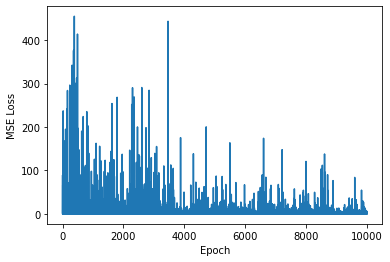

In [18]:
plt.plot(losses, '-')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

In [22]:
class FFN(nn.Module):

    def __init__(self, sizes, activation=nn.ReLU, output_activation=nn.Identity, batch_norm=False):
        super().__init__()
        
        layers = [nn.BatchNorm1d(sizes[0]),] if batch_norm else []
        for j in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[j], sizes[j+1]))
            if batch_norm:
                layers.append(nn.BatchNorm1d(sizes[j+1], affine=True))
            if j<(len(sizes)-2):
                layers.append(activation())
            else:
                layers.append(output_activation())

        self.net = nn.Sequential(*layers)

    def freeze(self):
        for p in self.parameters():
            p.requires_grad=False

    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad=True

    def forward(self, x):
        return self.net(x)

In [20]:
net = FFN([3, 100, 100, 2])
optimizer = optim.Adam(net.parameters(), lr=lr)
criterion = nn.MSELoss()

losses = []
for epoch in tqdm(range(num_epochs)):
    t = np.random.uniform(0, T)
    x = [np.random.uniform(-3, 3), np.random.uniform(-3, 3)]
    lqr = LQR(H, M, sigma, C, R, D, 1)
    y_true = torch.tensor(lqr.getValue(torch.tensor([t]), torch.tensor([[x]], dtype=torch.float32)))
    optimizer.zero_grad()
    tx = torch.cat([torch.tensor([[t]], dtype=torch.float32), torch.tensor([x])], 1)
    y_pred = net(tx)
    loss = criterion(y_pred, y_true)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|██████████| 10000/10000 [01:28<00:00, 112.39it/s]


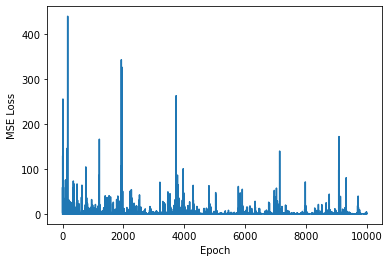

In [21]:
plt.plot(losses, '-')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

Exercise 3

In [23]:
def get_gradient(output, x):
    grad = torch.autograd.grad(output, x, grad_outputs=torch.ones_like(output), create_graph=True, retain_graph=True, only_inputs=True)[0]
    return grad

def get_laplacian(grad, x):
    hess = []
    for d in range(x.shape[1]):
        v = grad[:,d].view(-1,1)
        grad2 = torch.autograd.grad(v,x,grad_outputs=torch.ones_like(v), only_inputs=True, create_graph=True, retain_graph=True)[0]
        hess.append(grad2)
    return torch.cat(hess, 1)

class PDE_DGM(nn.Module):

    def __init__(self, d: int, hidden_dim: int, H, M, sigma, C, R, D, ts: torch.Tensor=None, device: str='cpu'):

        super().__init__()
        self.d = d
        self.net_dgm = Net_DGM(d, hidden_dim, activation='Tanh')
        self.H = torch.tensor(H, device=device)
        self.M = torch.tensor(M, device=device)
        self.sigma = torch.tensor(sigma, device=device)
        self.C = torch.tensor(C, device=device)
        self.R = torch.tensor(R, device=device)
        self.D = torch.tensor(D, device=device)
        self.alpha = torch.tensor([[1], [1]], device=device)
        self.ts = ts

    def fit(self, max_updates: int, batch_size: int, device):

        optimizer = torch.optim.Adam(self.net_dgm.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = (10000,),gamma=0.1)
        loss_fn = nn.MSELoss()
        
        pbar = tqdm(total=max_updates)
        loss_value = []
        for it in range(max_updates):
            optimizer.zero_grad()

            input_domain = 6 * torch.rand(batch_size, self.d, device=device, requires_grad=True) - 3
            t0, T = self.ts[0], self.ts[-1]
            t = t0 + T*torch.rand(batch_size, 1, device=device, requires_grad=True)
            t_T = torch.ones(batch_size, 1, device=device) * T
            u_of_tx = self.net_dgm(t, input_domain)
            u_of_Tx = self.net_dgm(t_T, input_domain)
            grad_u_x = get_gradient(u_of_tx,input_domain)
            grad_u_t = get_gradient(u_of_tx, t)
            laplacian = get_laplacian(grad_u_x, input_domain)
            target = torch.zeros_like(u_of_tx)
            R1, R2 = 0, 0
            eqn = []
            boundary = []
            for i in range(laplacian.shape[0]):
                x = laplacian[i]
                temp_x = x.cpu().detach().numpy().reshape(2,2)
                x_i = input_domain[i].cpu().detach().numpy()
                grad_u_x_i = grad_u_x[i].cpu().detach().numpy()
                alpha_np = self.alpha.cpu().numpy()
                temp_value = abs(grad_u_t[i].cpu().detach().numpy()
                         + 1/2*np.trace(self.sigma.cpu().numpy() @ self.sigma.cpu().numpy().T @ temp_x)
                         + grad_u_x_i.T @ self.H.cpu().numpy() @ x_i
                         + grad_u_x_i.T @ self.M.cpu().numpy() @ alpha_np
                         + grad_u_x_i.T @ self.M.cpu().numpy() @ alpha_np
                         + x_i.T @ self.C.cpu().numpy() @ x_i
                         + alpha_np.T @ self.D.cpu().numpy() @ alpha_np
                        )**2
                eqn.append(temp_value.tolist()[0])
                temp_value = abs(u_of_Tx[i].cpu().detach().numpy() - x_i.T @ self.R.cpu().numpy() @ x_i)**2
                boundary.append(temp_value.tolist()[0])
            eqn = torch.tensor(eqn, device=device, requires_grad = True)
            boundary = torch.tensor(boundary, device=device, requires_grad = True)
            MSE_eqn = loss_fn(eqn, target)
            MSE_boundary = loss_fn(boundary, target)

            loss = MSE_eqn + MSE_boundary
            loss_value.append(loss.cpu().detach().item())
            loss.backward()
            optimizer.step()
            scheduler.step()
            if it%10 == 0:
                pbar.update(10)
                pbar.write("Iteration: {}/{}\t MSE eqn: {:.4f}\t MSE boundary: {:.4f}\t Total Loss: {:.4f}".format(it, max_updates, MSE_eqn.item(), MSE_boundary.item(), loss.item()))
        plt.plot(loss_value, '-')
        plt.xlabel('Updates')
        plt.ylabel('MSE Loss')
        plt.show()

In [24]:
def train(T,
        n_steps,
        d,
        hidden_dim,
        max_updates,
        batch_size, 
        base_dir,
        device,
        ):
    
    logfile = os.path.join(base_dir, "log.txt")
    ts = torch.linspace(0,T,n_steps+1, device=device)
    pde_solver = PDE_DGM(d, hidden_dim, H, M, sigma, C, R, D, ts=ts, device=device)
    pde_solver.to(device)
    pde_solver.fit(max_updates=max_updates,
                     batch_size=batch_size, 
                     device=device)
    


In [27]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device="cpu"


seed = 1
set_seed(seed)
results_path = os.path.join('./numerical_results/', "PDE_DGM", "seed{}".format(seed))
if not os.path.exists(results_path):
    os.makedirs(results_path)

train(T=1,
    n_steps=50,
    d=2,
    hidden_dim=100,
    max_updates=5000,
    batch_size=500,
    base_dir=results_path,
    device=device,
    )


  0%|          | 10/5000 [00:00<04:27, 18.63it/s]
                                                  
 19%|█▊        | 930/5000 [08:49<39:18,  1.73it/s][A

Iteration: 0/5000	 MSE eqn: 11.8505	 MSE boundary: 5202.9175	 Total Loss: 5214.7681



  0%|          | 20/5000 [00:06<31:13,  2.66it/s]
                                                  
 19%|█▊        | 930/5000 [08:55<39:18,  1.73it/s][A

Iteration: 10/5000	 MSE eqn: 11.6955	 MSE boundary: 7019.5146	 Total Loss: 7031.2100



  1%|          | 30/5000 [00:12<39:25,  2.10it/s]
                                                  
 19%|█▊        | 930/5000 [09:01<39:18,  1.73it/s][A

Iteration: 20/5000	 MSE eqn: 11.8035	 MSE boundary: 5286.6064	 Total Loss: 5298.4102



  1%|          | 40/5000 [00:18<42:04,  1.96it/s]
                                                  
 19%|█▊        | 930/5000 [09:06<39:18,  1.73it/s][A

Iteration: 30/5000	 MSE eqn: 11.7040	 MSE boundary: 5479.1909	 Total Loss: 5490.8950



  1%|          | 50/5000 [00:23<43:52,  1.88it/s]
                                                  
 19%|█▊        | 930/5000 [09:12<39:18,  1.73it/s][A

Iteration: 40/5000	 MSE eqn: 11.7777	 MSE boundary: 5089.3506	 Total Loss: 5101.1284



  1%|          | 60/5000 [00:29<44:29,  1.85it/s]
                                                  
 19%|█▊        | 930/5000 [09:18<39:18,  1.73it/s][A

Iteration: 50/5000	 MSE eqn: 11.9308	 MSE boundary: 6236.4570	 Total Loss: 6248.3877



  1%|▏         | 70/5000 [00:35<45:18,  1.81it/s]
                                                  
 19%|█▊        | 930/5000 [09:23<39:18,  1.73it/s][A

Iteration: 60/5000	 MSE eqn: 11.7848	 MSE boundary: 5213.2236	 Total Loss: 5225.0083



  2%|▏         | 80/5000 [00:40<45:54,  1.79it/s]
                                                  
 19%|█▊        | 930/5000 [09:29<39:18,  1.73it/s][A

Iteration: 70/5000	 MSE eqn: 11.8514	 MSE boundary: 5623.4907	 Total Loss: 5635.3423



  2%|▏         | 90/5000 [00:46<46:25,  1.76it/s]
                                                  
 19%|█▊        | 930/5000 [09:35<39:18,  1.73it/s][A

Iteration: 80/5000	 MSE eqn: 11.8047	 MSE boundary: 4936.2314	 Total Loss: 4948.0361



  2%|▏         | 100/5000 [00:52<46:21,  1.76it/s]
                                                  
 19%|█▊        | 930/5000 [09:41<39:18,  1.73it/s]

Iteration: 90/5000	 MSE eqn: 11.6705	 MSE boundary: 5130.6396	 Total Loss: 5142.3101



  2%|▏         | 110/5000 [00:58<46:40,  1.75it/s]
                                                  
 19%|█▊        | 930/5000 [09:46<39:18,  1.73it/s]

Iteration: 100/5000	 MSE eqn: 11.8930	 MSE boundary: 5762.2139	 Total Loss: 5774.1069



  2%|▏         | 120/5000 [01:04<46:51,  1.74it/s]
                                                  
 19%|█▊        | 930/5000 [09:52<39:18,  1.73it/s]

Iteration: 110/5000	 MSE eqn: 11.6425	 MSE boundary: 5198.6045	 Total Loss: 5210.2471



  3%|▎         | 130/5000 [01:09<46:53,  1.73it/s]
                                                  
 19%|█▊        | 930/5000 [09:58<39:18,  1.73it/s]

Iteration: 120/5000	 MSE eqn: 11.6097	 MSE boundary: 5895.1099	 Total Loss: 5906.7197



  3%|▎         | 140/5000 [01:15<46:39,  1.74it/s]
                                                  
 19%|█▊        | 930/5000 [10:04<39:18,  1.73it/s]

Iteration: 130/5000	 MSE eqn: 11.7736	 MSE boundary: 6226.5103	 Total Loss: 6238.2837



  3%|▎         | 150/5000 [01:21<46:15,  1.75it/s]
                                                  
 19%|█▊        | 930/5000 [10:09<39:18,  1.73it/s]

Iteration: 140/5000	 MSE eqn: 11.8629	 MSE boundary: 5308.5557	 Total Loss: 5320.4185



  3%|▎         | 160/5000 [01:26<45:55,  1.76it/s]
                                                  
 19%|█▊        | 930/5000 [10:15<39:18,  1.73it/s]

Iteration: 150/5000	 MSE eqn: 11.8079	 MSE boundary: 6164.4355	 Total Loss: 6176.2437



  3%|▎         | 170/5000 [01:32<45:53,  1.75it/s]
                                                  
 19%|█▊        | 930/5000 [10:21<39:18,  1.73it/s]

Iteration: 160/5000	 MSE eqn: 11.7190	 MSE boundary: 5102.1855	 Total Loss: 5113.9048



  4%|▎         | 180/5000 [01:38<45:51,  1.75it/s]
                                                  
 19%|█▊        | 930/5000 [10:27<39:18,  1.73it/s]

Iteration: 170/5000	 MSE eqn: 11.5629	 MSE boundary: 5959.5444	 Total Loss: 5971.1074



  4%|▍         | 190/5000 [01:44<45:54,  1.75it/s]
                                                  
 19%|█▊        | 930/5000 [10:32<39:18,  1.73it/s]

Iteration: 180/5000	 MSE eqn: 11.9559	 MSE boundary: 4824.8623	 Total Loss: 4836.8184



  4%|▍         | 200/5000 [01:49<45:43,  1.75it/s]
                                                  
 19%|█▊        | 930/5000 [10:38<39:18,  1.73it/s]

Iteration: 190/5000	 MSE eqn: 11.7737	 MSE boundary: 6010.2549	 Total Loss: 6022.0288



  4%|▍         | 210/5000 [01:55<45:42,  1.75it/s]
                                                  
 19%|█▊        | 930/5000 [10:44<39:18,  1.73it/s]

Iteration: 200/5000	 MSE eqn: 11.6272	 MSE boundary: 6575.3257	 Total Loss: 6586.9531
